# 変分オートエンコーダ

In [2]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optimizers
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

### 変分オートエンコーダの概要
変分オートエンコーダ(Varietional Auto Encoder：VAE)  
生成モデルの一種でモデル分布$p_\theta(x)$の尤度(もっともらしさ)を最大となるパラメータを計算する.  
VAEは尤度を観測変数と潜在変数の二つに分解して計算する.  
観測変数$x$は画像などの実際に観測可能な確率変数で,潜在変数$z$は実際に観測できない確率変数である.  
VAEは潜在変数$z$を導入することで,モデル分布$p_\theta(x)$を$p_\theta(z)$と$p_\theta(x|z)$の二つに分解することができて,  
潜在変数$z$の積分で計算できる.  
$p_\theta(x) = \int_{}{}p_\theta(x|z)p_\theta(z)dz$  
この時,$p_\theta(z)$は潜在変数$z$の確率分布になり,$p_\theta(x|z)$は潜在変数$z$が与えられた時の観測変数$x$の条件付確率になる.  
VAEはエンコーダの潜在変数$z$を標準正規分布に従う確率変数にモデル化する。このモデル化により,学習に使用する入力データの特徴量を標準正規分布に落とし込み,デコーダーに標準正規分布を入力して画像を生成できるようにしている.
学習が終わるとエンコーダが不要となり,デコーダーに標準正規分布に従う確率変数から,入力データ$x'$を確率的に生成できる.

### モジュールの定義

In [3]:
class Encoder(nn.Module):
    def __init__(self, z_dim):
        """
        入力データ28x28(784)次元を200次元に線形変換し、続いて200次元を10次元に線形変換する平均と分散の全結合層
        """
        super().__init__()
        self.l1 = nn.Linear(784, 200)
        self.l_mean = nn.Linear(200, z_dim)
        self.l_var = nn.Linear(200, z_dim)
    
    def forward(self, x):
        # 784次元から200次元
        x = self.l1(x)
        # 活性化関数
        x = F.relu(x)
        # 200次元から10次元の平均
        mean = self.l_mean(x)
        # 200次元から10次元の分散
        var = self.l_var(x)
        # 活性化関数(入力値を0.0から無限大に変換)
        var = F.softplus(var)

        return mean, var

class Decoder(nn.Module):
    def __init__(self, z_dim):
        super().__init__()
        self.l1 = nn.Linear(z_dim, 200)
        self.out = nn.Linear(200, 784)
    
    def forward(self, x):
        # 10次元から200次元
        x = self.l1(x)
        # 活性化関数
        x = F.relu(x)
        # 200次元から784次元
        x = self.out(x)
        # シグモイド関数
        x = F.sigmoid(x)

        return x

### VAEのモデル化

In [4]:
class VAE(nn.Module):
    def __init__(self, z_dim):
        super().__init__()
        self.z_dim = z_dim
        self.encoder = Encoder(z_dim=self.z_dim)
        self.decoder = Decoder(z_dim=self.z_dim)
    
    def forward(self, x):
        # エンコーダ
        mean, var = self.encoder(x)
        # 潜在変数の作成
        z = self.reparameterize(mean, var)
        # デコーダ
        x = self.decoder(z)
        
        return x, mean, var

    def reparameterize(self, mean:torch, var:torch):
        """ 潜在変数zの作成

        Args:
            mean (torch): 平均
            var (torch): 分散

        Returns:
            torch : 潜在変数z
        """
        eps = torch.randn(mean.size())
        z = mean + torch.sqrt(var) * eps

        return z

### VAEの損失関数
損失関数は再構成誤差に加えて,潜在変数が標準正規分布に従うよう,正則化の誤差を考慮する必要がある.  
そのため、VAEの損失関数$J$は再構成誤差の損失関数$J^{REC}$と正則化の損失関数$J^{REG}$の合計になる.  
$J = J^{REC} + J^{REG}$  
再構成誤差(バイナリークロスエントロピー)  
$J^{REC} = -\frac{1}{N}\sum_{i=1}^{N}(x_ilogy_i+(1-x_i)log(1-y_i))$  
正則化の損失関数は平均$\mu$, 分散$\sigma^{2}$を使用し,次の式になる.  
$J^{REG}=-\frac{1}{n}\sum_{j=1}^{J}(1+log\sigma_j^{2}-\mu_j^{2}-\sigma_j^{2})$  
正則化項は潜在変数zが標準正規分布に近づくようにする損失である.


In [5]:
# 誤差の計算
def lower_bound(x, y, mean, var):
    # 再構成誤差
    reconst = - torch.mean(torch.sum(x*torch.log(y) + (1-x)*torch.log(1-y), dim=1))
    # 正則化
    kl = - 1/2 * torch.mean(torch.sum(1 + torch.log(var) - mean**2 - var, dim=1))
    # 再構成誤差 + 正則化
    L = reconst + kl

    return L

# 正則化
def kl_loss(mean, var):
    kl = kl = - 1/2 * torch.mean(torch.sum(1 + torch.log(var) - mean**2 - var, dim=1))
    return kl

# 再構成誤差
def recon_loss(x, y):
    # 再構成誤差
    reconst = - torch.mean(torch.sum(x*torch.log(y) + (1-x)*torch.log(1-y), dim=1))
    return reconst

### データセットの作成

In [6]:
np.random.seed(1234)
torch.manual_seed(1234)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# データの取得
root = os.path.join('data', 'mnist')
transform = transforms.Compose([transforms.ToTensor(), lambda x: x.view(-1)])

mnist_train = torchvision.datasets.MNIST(root=root, download=True, train=True, transform=transform)
mnist_test = torchvision.datasets.MNIST(root=root, download=True, train=False, transform=transform)

# データローダー
train_dataloader = DataLoader(mnist_train, batch_size=100, shuffle=True, pin_memory=True)
test_dataloader = DataLoader(mnist_test, batch_size=100, shuffle=False, pin_memory=True)


### 学習の実行
cpuで行うためtrainのみで行う

In [7]:
z_dim = 10
# モデルの設定
model = VAE(z_dim).to(device)
# 損失関数の設定
criterion = lower_bound
# 最適化関数の設定
optimizer = optimizers.Adam(model.parameters())
print(model)

VAE(
  (encoder): Encoder(
    (l1): Linear(in_features=784, out_features=200, bias=True)
    (l_mean): Linear(in_features=200, out_features=10, bias=True)
    (l_var): Linear(in_features=200, out_features=10, bias=True)
  )
  (decoder): Decoder(
    (l1): Linear(in_features=10, out_features=200, bias=True)
    (out): Linear(in_features=200, out_features=784, bias=True)
  )
)


In [11]:
epochs = 10
kl_loss_list = []
recon_loss_list = []
# エポックのループ
for epoch in range(epochs):
    train_loss = 0.0
    # 訓練モード
    model.train()
    
    # バッチサイズのループ
    for (x, _) in train_dataloader:
        x = x.to(device)
        y, mean, var = model(x)
        # 本物画像と生成画像の誤差計算
        loss = kl_loss(mean, var)
        # 勾配の初期化
        optimizer.zero_grad()
        # 誤差の勾配計算
        loss.backward()
        # パラメータの更新
        optimizer.step()
        # 訓練誤差の更新
        train_loss += loss.item()
    train_loss /= len(train_dataloader)
    kl_loss_list.append(train_loss)

    print('Epoch: {}, loss: {:.3f}'.format(epoch+1, train_loss))

for epoch in range(epochs):
    train_loss = 0.0
    # 訓練モード
    model.train()
    model.encoder.eval()
    
    # バッチサイズのループ
    for (x, _) in train_dataloader:
        x = x.to(device)
        y, mean, var = model(x)
        # 本物画像と生成画像の誤差計算
        loss = recon_loss(x, y)
        # 勾配の初期化
        optimizer.zero_grad()
        # 誤差の勾配計算
        loss.backward()
        # パラメータの更新
        optimizer.step()
        # 訓練誤差の更新
        train_loss += loss.item()
    train_loss /= len(train_dataloader)
    recon_loss_list.append(train_loss)

    print('Epoch: {}, loss: {:.3f}'.format(epoch+1, train_loss))

Epoch: 1, loss: 6.406
Epoch: 2, loss: 0.139
Epoch: 3, loss: 0.059
Epoch: 4, loss: 0.029
Epoch: 5, loss: 0.015
Epoch: 6, loss: 0.007
Epoch: 7, loss: 0.003
Epoch: 8, loss: 0.001
Epoch: 9, loss: 0.001
Epoch: 10, loss: 0.000
Epoch: 1, loss: 104.134
Epoch: 2, loss: 89.061
Epoch: 3, loss: 88.205
Epoch: 4, loss: 87.673
Epoch: 5, loss: 87.260
Epoch: 6, loss: 86.904
Epoch: 7, loss: 86.625
Epoch: 8, loss: 86.365
Epoch: 9, loss: 86.135
Epoch: 10, loss: 85.914


### 学習曲線

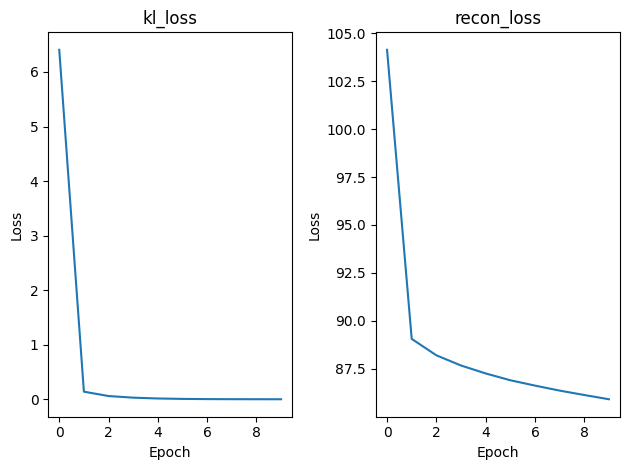

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].plot(kl_loss_list)
ax[0].set_title("kl_loss")
ax[1].plot(recon_loss_list)
ax[1].set_title("recon_loss")
ax[0].set_xlabel("Epoch")
ax[1].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[1].set_ylabel("Loss")
plt.tight_layout()
plt.show()


### 画像の生成

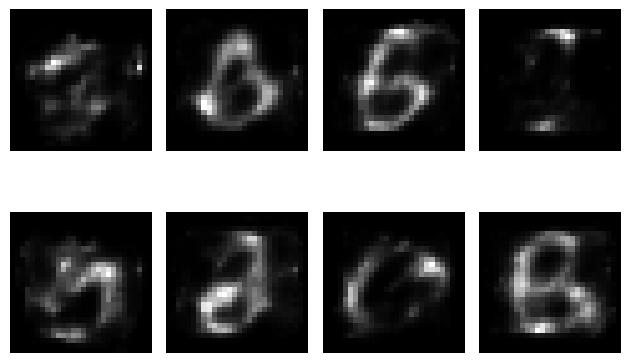

In [15]:
# ノイズの作成数
batch_size = 8
# デコーダ入力用に標準正規分布に従うz_dimのノイズを作成
z = torch.randn(batch_size, z_dim, device=device)

# 評価モードへの切り替え
model.eval()
# デコーダにノイズzを入力
images = model.decoder(z)
images = images.view(-1, 28, 28)
images = images.squeeze().detach().cpu().numpy()

for i, image in enumerate(images):
    plt.subplot(2, 4, i+1)
    plt.imshow(image, cmap='binary_r')
    plt.axis('off')
plt.tight_layout()
plt.show()

本物画像と生成画像の比較

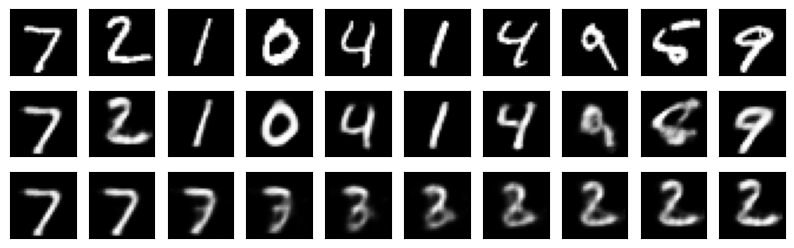

In [14]:
fig = plt.figure(figsize=(10, 3))
# 推論モード
model.eval()
for x, t in test_dataloader:
    # 本物画像 10枚取得
    for i, im in enumerate(x.view(-1, 28, 28).detach().numpy()[:10]):
        ax = fig.add_subplot(3, 10, i+1, xticks=[], yticks=[])
        ax.imshow(im, 'gray')
    # 本物画像から生成画像
    y, mean, var = model(x)
    y = y.view(-1, 28, 28)
    for i, im in enumerate(y.detach().cpu().numpy()[:10]):
        ax = fig.add_subplot(3, 10, i+11, xticks=[], yticks=[])
        ax.imshow(im, 'gray')
    # 1つ目の画像と2つ目の画像の潜在変数を連続的に変化
    z = model.reparameterize(mean, var)
    z1to0 = torch.cat([z[1] * (i * 0.1) + z[0] * ((9 - i) * 0.1) for i in range(10)]).reshape(10, 10)
    y2 = model.decoder(z1to0).view(-1, 28, 28)
    for i, im in enumerate(y2.detach().cpu().numpy()):
        ax = fig.add_subplot(3, 10, i+21, xticks=[], yticks=[])
        ax.imshow(im, 'gray')
    break
plt.show()